# Machine Learning Engineer Nanodegree
## Capstone Project - InstaCart Market Basket Analysis

### Data Exploration and Visualization

The dataset is sizeable and reading in csv files to pandas dataframes takes enough time that storing the dataframes in a native format saves significant time. After some research using Google, I found that dataframes stores in hdfs was significantly faster and opted to save a copy of the original dataset in this format.

This notebook includes code, output and images for our preliminary exploration of the dataset.

In [1]:
# Import libraries necessary for this project
# Using hdfs for storing pandas dataframes requires the `tables` module to be available in the environment

import numpy as np
import pandas as pd
#import renders as rs
#from IPython.display import display # Allows the use of display() for DataFrames

import sqlite3
import os

# Import additional graphics libraries
import matplotlib.pyplot as plt
import seaborn as sb
sb.set(style="whitegrid", color_codes=True)

# Show matplotlib plots inline (nicely formatted in the notebook)
%matplotlib inline

print "Loaded libraries"
_datapath='C:/Users/Zeta/Documents/Kaggle/Instacart'
_datapath='./'

import os
#os.chdir(_datapath)
#db='instdb.sql'
HDF_STORE = 'instacart_raw.hdf5'

Loaded libraries


## Convert datset from csv to hdfs

Read and store data from csv files
1. Load DataFrame from CSV files.
2. Save Dataframe using to_hdfs. 

#### _This is done once only!!! _  In subsequent passes, we read from the HDFS store directly

In [2]:
%%time

try:

    # Load selected tables from the wholesale customers dataset
    if os.path.isfile(HDF_STORE):
        print "Loading datasets ..."
        aisle = pd.read_hdf(HDF_STORE, "aisles")
        departments = pd.read_hdf(HDF_STORE, "departments")
        products = pd.read_hdf(HDF_STORE, "products")
        orders = pd.read_hdf(HDF_STORE, "orders")
    else:
        print "Loading aisles ..."
        aisles = pd.read_csv("aisles.csv")
        print "Loading departments ..."
        departments = pd.read_csv("departments.csv")
        print "Loading products ..."
        products = pd.read_csv("products.csv")

        print "Saving as hdfs ..."
        aisles.to_hdf(HDF_STORE, "aisles")
        departments.to_hdf(HDF_STORE, "departments")
        products.to_hdf(HDF_STORE, "products")

        # orders
        print "Loading orders ..."
        orders = pd.read_csv('orders.csv', engine='c', dtype={'order_id': np.uint32, 
                                                               'user_id': np.uint32, 
                                                               'order_number': np.int8, 
                                                               'order_dow': np.int8, 
                                                               'order_hour_of_day': np.int8, 
                                                               'days_since_prior_order': np.float})
        orders.eval_set = orders.eval_set.replace({'prior': 0, 'train': 1, 'test':2}).astype(np.int8)
        print "Saving orders ..."
        orders.to_hdf(HDF_STORE, "orders")
        

    print('Total orders: {}'.format(orders.shape[0]))

except Exception as  e:
    print e
    print "Dataset could not be loaded. Is the dataset missing?"

Loading datasets ...
Total orders: 3421083
Wall time: 589 ms


#### Continue converting the larger data tables ordes_products and train_products

In [5]:
%%time

def load_order_products(STORE):
    print "Loading order_product table - all prior products ... "
    op_prior = pd.read_csv('order_products__prior.csv', engine='c', 
                           dtype={'order_id': np.uint32, 
                                  'product_id': np.uint16, 
                                  'add_to_cart_order': np.uint16, 
                                  'reordered': np.int8})
    print "Saving as hdfs .. "
    op_prior.to_hdf(STORE, 'priors')
    print "Loading order_products table - train set ... "
    op_train = pd.read_csv('order_products__train.csv', engine='c', 
                           dtype={'order_id': np.uint32, 
                                  'product_id': np.uint16, 
                                  'add_to_cart_order': np.uint16, 
                                  'reordered': np.int8})
    op_train.to_hdf(STORE, 'train')
    return op_prior
    
try:
    if os.path.isfile(HDF_STORE):
        priors = pd.read_hdf(HDF_STORE,'priors')
    else:
        priors = load_order_products(HDF_STORE)
    print('Total priors: {}'.format(priors.shape[0]))    

except MemoryError as e:
    print e
    del op_prior
     
except KeyError as e:
    print e
    priors = load_order_products(HDF_STORE)
    print('Total priors: {}'.format(priors.shape[0]))    
    


Total priors: 32434489
Wall time: 1.2 s


###  Simple exploration of _products_, _departments_ and _aisles_

We summarize the data from these smaller tables first


In [9]:
#Departments
print(departments.tail())
print(departments.describe())

    department_id department
16             17  household
17             18     babies
18             19     snacks
19             20       deli
20             21    missing
       department_id
count      21.000000
mean       11.000000
std         6.204837
min         1.000000
25%         6.000000
50%        11.000000
75%        16.000000
max        21.000000


In [10]:
# Aisles
print(aisles.tail())
aisles.describe()

     aisle_id                       aisle
129       130    hot cereal pancake mixes
130       131                   dry pasta
131       132                      beauty
132       133  muscles joints pain relief
133       134  specialty wines champagnes


,aisle_id
count,134.000000
mean,67.500000
std,38.826537
min,1.000000
25%,34.250000
50%,67.500000
75%,100.750000
max,134.000000


In [6]:
# Products
products.head()

,product_id,product_name,department_id,aisle_id
index,,,,
0,1,Chocolate Sandwich Cookies,19,61
1,78,Nutter Butter Cookie Bites Go-Pak,19,61
2,102,Danish Butter Cookies,19,61
3,172,Gluten Free All Natural Chocolate Chip Cookies,19,61
4,285,Mini Nilla Wafers Munch Pack,19,61


In [11]:
# 'Missing' -- there is one department and one aisle labeled missing
print(departments[departments.department == 'missing'])
print(aisles[aisles.aisle == 'missing'])
missing = products[products.department_id == 21].reset_index()
#print(aisles[aisles.aisle_id==100])
print "{:d} products items are associated with department='missing'".format(len(missing))
missing.head()                                                                        

    department_id department
20             21    missing
    aisle_id    aisle
99       100  missing
1258 products items are associated with department='missing'


,index,product_id,product_name,aisle_id,department_id
0,37,38,Ultra Antibacterial Dish Liquid,100,21
1,71,72,Organic Honeycrisp Apples,100,21
2,109,110,Uncured Turkey Bologna,100,21
3,296,297,"Write Bros Ball Point Pens, Cap-Pen, Medium (1...",100,21
4,416,417,Classics Baby Binks Easter Chocolate Bunny,100,21


#### The _orders_ Table

This table has 7 columns describing the order. The `eval_set` column was mapped to integers for memory conservation. This table (and the orders_product table) is partitioned into three sets for each of the three unique values of `eval_set`. There is no overlap of `user_id`s between the `train` and `test` paritions.

The count of unique order_ids and user_ids allows us to infer that the training test sets contain 1 order for each user_id.

In [12]:
# orders table detail
print "The eval_set column has been mapped to an integer: 0='prior', 1='train' and 2='test'."
orders.head()

The eval_set column has been mapped to an integer: 0='prior', 1='train' and 2='test'.


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,0,1,2,8,NaN
1,2398795,1,0,2,3,7,15.0
2,473747,1,0,3,3,12,21.0
3,2254736,1,0,4,4,7,29.0
4,431534,1,0,5,4,15,28.0


In [13]:
#Summarize
print("{} unique user_id in orders".format(len(orders.user_id.unique())))
print("{} unique orders in train".format(len(orders[orders.eval_set==1].order_id.unique())))
print("{} unique user_id in train".format(len(orders[orders.eval_set==1].user_id.unique())))
print("{} unique user_id in test".format(len(orders[orders.eval_set==2].user_id.unique())))
train = orders[orders.eval_set==1]
test = orders[orders.eval_set==2]
print("{} user_id in test with orders in train".format(\
                        len(test[test.user_id.isin(train.user_id)].user_id.unique())) )


206209 unique user_id in orders
131209 unique orders in train
131209 unique user_id in train
75000 unique user_id in test
0 user_id in test with orders in train


In [26]:
priors.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


### The _orders_ and _order-products_ tables can be partitioned into three sets 

The `eval_set` field in the _orders_ table identifies whether an order (or order/product combination) belongs to the train, test or simple history set.


In [31]:
od = orders.groupby('eval_set')['order_id'].count().reset_index()
od.rename(columns={'order_id':'Count'}, inplace=True)
od.head()

,eval_set,Count
0,0,3214874
1,1,131209
2,2,75000


### Distribution of orders in each set by order_dow

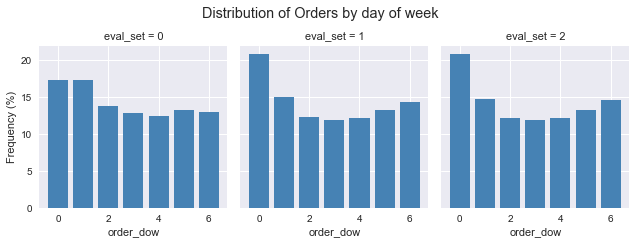

In [55]:
od=orders.groupby(['eval_set','order_dow'])['order_id'].count().reset_index().rename(columns={'order_id':'Count'})
odc = od.groupby('eval_set')['Count'].sum().reset_index().rename(columns={'Count':'Total'})
od=od.merge(odc, how='left', on='eval_set')
od.loc[:,"Frequency (%)"]=od[['Count','Total']].apply(lambda x: 100.0*x[0]/x[-1], axis=1)

sb.set(style="darkgrid")
g = sb.FacetGrid(od, col="eval_set", margin_titles=True)
#plt.subplots_adjust(top=1.0)
g.map(plt.bar,"order_dow", "Frequency (%)", color="steelblue",  lw=0)
plt.subplots_adjust(top=0.8, bottom=0.05)
_= g.fig.suptitle(" Distribution of Orders by day of week")
del od, odc

### Distribution of orders in each set by order_hour_of_day

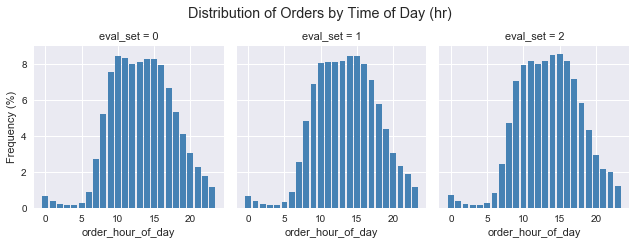

In [56]:
od=orders.groupby(['eval_set','order_hour_of_day'])['order_id'].count().reset_index().rename(columns={'order_id':'Count'})
odc = od.groupby('eval_set')['Count'].sum().reset_index().rename(columns={'Count':'Total'})
od=od.merge(odc, how='left', on='eval_set')
od.loc[:,"Frequency (%)"]=od[['Count','Total']].apply(lambda x: 100.0*x[0]/x[-1], axis=1)

g = sb.FacetGrid(od, col="eval_set", margin_titles=True)
g.map(plt.bar,"order_hour_of_day", "Frequency (%)", color="steelblue",  lw=0)
plt.subplots_adjust(top=0.8, bottom=0.05)
_= g.fig.suptitle(" Distribution of Orders by Time of Day (hr)")
del od, odc

### Distribution of orders in each set by days_since_prior_order

In [58]:
orders.days_since_prior_order.fillna(32,inplace=True)
od=orders.groupby(['eval_set','days_since_prior_order'])['order_id'].count().reset_index().rename(columns={'order_id':'Count'})

odc = od.groupby('eval_set')['Count'].sum().reset_index().rename(columns={'Count':'Total'})
od=od.merge(odc, how='left', on='eval_set')
od.loc[:,"Normalized Count"]=od[['Count','Total']].apply(lambda x: 100.0*x[0]/x[-1], axis=1)
print od.describe()
od.head()

        eval_set  days_since_prior_order          Count         Total  \
count  94.000000               94.000000      94.000000  9.400000e+01   
mean    0.989362               15.180851   36394.500000  1.162430e+06   
std     0.822985                9.114520   69206.815839  1.482603e+06   
min     0.000000                0.000000     670.000000  7.500000e+04   
25%     0.000000                7.250000    1733.000000  7.500000e+04   
50%     1.000000               15.000000    3153.000000  1.312090e+05   
75%     2.000000               23.000000   32639.500000  3.214874e+06   
max     2.000000               32.000000  306181.000000  3.214874e+06   

       Normalized Count  
count         94.000000  
mean           3.191489  
std            4.518158  
min            0.528046  
25%            1.199868  
50%            2.092990  
75%            3.462459  
max           30.756000  


,eval_set,days_since_prior_order,Count,Total,Normalized Count
0,0,0.0,64436,3214874,2.004309
1,0,1.0,141011,3214874,4.386206
2,0,2.0,187723,3214874,5.839202
3,0,3.0,210665,3214874,6.552823
4,0,4.0,214488,3214874,6.671739


### Distribution of `days_since_prior_order` across `history`, `train` and `test` sets

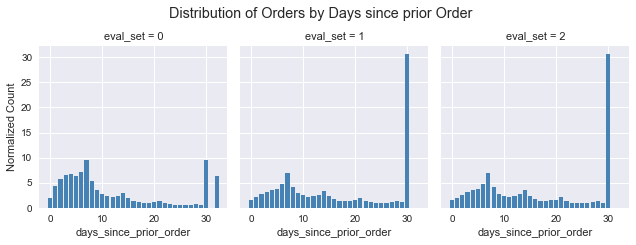

In [59]:
sb.set(style="darkgrid")
g = sb.FacetGrid(od, col="eval_set", margin_titles=True)
g.map(plt.bar,"days_since_prior_order", "Normalized Count", color="steelblue",  lw=0)
plt.subplots_adjust(top=0.8, bottom=0.05)
_= g.fig.suptitle(" Distribution of Orders by Days since prior Order")

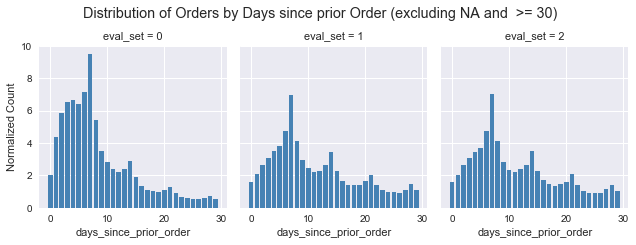

In [60]:
sb.set(style="darkgrid")
g = sb.FacetGrid(od[od.days_since_prior_order<30], col="eval_set", margin_titles=True)
g.map(plt.bar,"days_since_prior_order", "Normalized Count", color="steelblue",  lw=0)
plt.subplots_adjust(top=0.8, bottom=0.05)
_= g.fig.suptitle(" Distribution of Orders by Days since prior Order (excluding NA and  >= 30)")

In [19]:
#orders_sel = orders.merge(priors.groupby('order_id')['product_id'].count().reset_index(), how='left', on='order_id')
#orders_sel.rename(columns={'product_id':'order_size'}, inplace=True)
#import random
#rows = random.sample(orders_sel.index, 25000)
#orders_sample=orders_sel.ix[rows]
print len(orders_sample)
#[orders_sel.days_since_prior_order<29]

25000


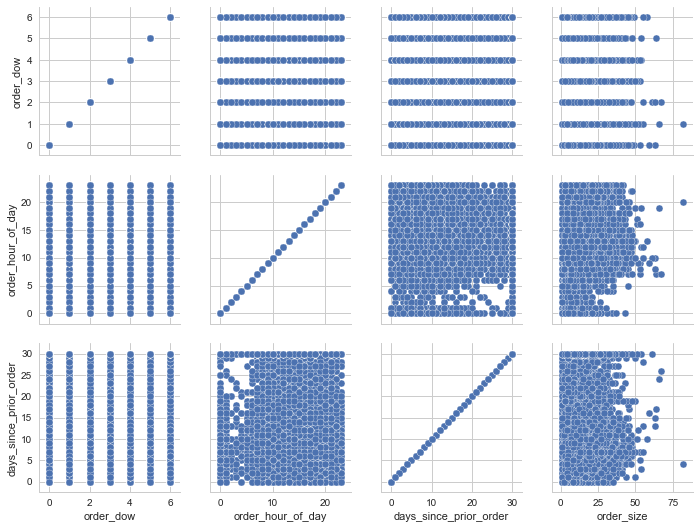

In [20]:
g = sb.pairplot(orders_sample, x_vars=["order_dow", "order_hour_of_day",'days_since_prior_order','order_size'],\
                y_vars=["order_dow", "order_hour_of_day",'days_since_prior_order'])

In [21]:
len(orders_sel[orders_sel.order_size>70])

268

In [74]:
od=orders_sel.groupby(['eval_set','order_size'])['order_id'].agg({'count':lambda x: np.shape(x)[0],\
                                                                  'logCount':lambda x: np.log(np.shape(x)[0])})
od=od.reset_index()
#od.logCount = np.log(od.Count)
od.head()

,eval_set,order_size,count,logCount
0,0,1.0,156748,11.962395
1,0,2.0,186993,12.138826
2,0,3.0,207027,12.240604
3,0,4.0,222081,12.310797
4,0,5.0,228330,12.338547


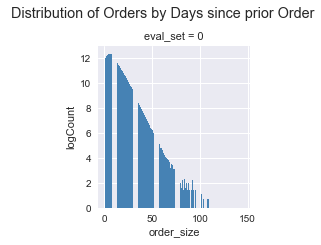

In [77]:
sb.set(style="darkgrid")
g = sb.FacetGrid(od, col="eval_set", margin_titles=True)
g.map(plt.bar,"order_size",  "logCount", color="steelblue",  lw=0)
plt.subplots_adjust(top=0.8, bottom=0.05)
_= g.fig.suptitle(" Distribution of Orders by Days since prior Order")